# Analysis of US Data Science Salary Survey

### Dowloaded from https://ai-jobs.net/salaries/download/

#### Guiding task: use dataset features to predict an individual's salary.

## 1. Import and read data

In [1]:
#global imports
import pandas as pd
import numpy as np
import seaborn as sns
import random

In [2]:
#display all dataset columns
pd.set_option('display.max_columns', 500)

df = pd.read_csv('salaries.csv')
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,MI,FT,Data Scientist,149800,USD,149800,US,0,US,M
1,2024,MI,FT,Data Scientist,70800,USD,70800,US,0,US,M
2,2024,SE,FT,Data Scientist,220000,USD,220000,US,0,US,M
3,2024,SE,FT,Data Scientist,137500,USD,137500,US,0,US,M
4,2024,SE,FT,Data Scientist,144300,USD,144300,US,100,US,M
...,...,...,...,...,...,...,...,...,...,...,...
19494,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
19495,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
19496,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
19497,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


## 2. Selecting features from dataset
### I am only interested in US salaries, so we will drop the appropriate records and columns.

In [3]:
#check for empty
df.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

#### woah! this dataset is almost usable out-the-box.

In [4]:
#check column types
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [5]:
#keep only the records of workers who live in the US, receive their salary in USD, and whose employer is US-based
df = df[(df['employee_residence'] == 'US') & (df['salary_currency'] == 'USD') & (df['company_location'] == 'US')]
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,MI,FT,Data Scientist,149800,USD,149800,US,0,US,M
1,2024,MI,FT,Data Scientist,70800,USD,70800,US,0,US,M
2,2024,SE,FT,Data Scientist,220000,USD,220000,US,0,US,M
3,2024,SE,FT,Data Scientist,137500,USD,137500,US,0,US,M
4,2024,SE,FT,Data Scientist,144300,USD,144300,US,100,US,M
...,...,...,...,...,...,...,...,...,...,...,...
19493,2021,SE,FT,Data Specialist,165000,USD,165000,US,100,US,L
19494,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
19495,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
19496,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S


In [6]:
# now, drop the columns that were only relevant for foreign records
df = df.drop(['salary_currency', 'salary_in_usd', 'employee_residence', 'company_location'], axis=1)
df

,work_year,experience_level,employment_type,job_title,salary,remote_ratio,company_size
0,2024,MI,FT,Data Scientist,149800,0,M
1,2024,MI,FT,Data Scientist,70800,0,M
2,2024,SE,FT,Data Scientist,220000,0,M
3,2024,SE,FT,Data Scientist,137500,0,M
4,2024,SE,FT,Data Scientist,144300,100,M
...,...,...,...,...,...,...,...
19493,2021,SE,FT,Data Specialist,165000,100,L
19494,2020,SE,FT,Data Scientist,412000,100,L
19495,2021,MI,FT,Principal Data Scientist,151000,100,L
19496,2020,EN,FT,Data Scientist,105000,100,S


### With the relevant features selected, the salary data in its current state is still not viable for comparison.
### We must adjust salaries for inflation.
#### To do that, we will evaluate the range of work years in our dataset as a parameter for scraping past inflation data 

In [7]:
# first, evaluate the earliest year in work_year
min_year = df['work_year'].min()
min_year

2020

In [8]:
# 2020 is as far back as we will have to go to find inflation data.
# find cumulative inflation rates for every year since 2024 (non-inlcusive)

## 3. Adjusting salary figures by inflation 
#### Scraping cumulative inflation rate with Selenium

In [9]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.select import Select

In [10]:
user_agents = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36',
    # Add more user agents
]

# set up the Selenium webdriver
options = Options()
options.add_argument("--headless=new")
options.add_argument(f"user-agent={random.choice(user_agents)}")
options.add_argument("--incognito")
driver = webdriver.Chrome(options=options)

# load the BLS page that calculates cumulative inflation rates
driver.get('https://data.bls.gov/cgi-bin/cpicalc.pl?cost1=1&year1=202001&year2=202401')

In [11]:
# implement for loop to calculate each year's cumulative inflation rate into 2024
# note: elements are fetched in every iteration because it threw error that elements became stale

cumulative_rates = {}

for i in range((2024 - min_year)):
    # enter $1
    init_dollar = driver.find_element(By.NAME, 'cost1')
    init_dollar.clear()
    init_dollar.send_keys("1")
    init_dollar.send_keys(Keys.RETURN)
    
    # assume initial month is always January
    init_month = driver.find_element(By.ID, 'year1-month')
    dropdown = Select(init_month)
    dropdown.select_by_visible_text('January')
    
    # fill in the initial year
    init_yr = driver.find_element(By.ID, 'year1-year')
    dropdown = Select(init_yr)
    current_yr = min_year + i
    dropdown.select_by_visible_text(str(current_yr))
    
    #assume end month is always January
    present_month = driver.find_element(By.ID, 'year2-month')
    dropdown = Select(present_month)
    dropdown.select_by_visible_text('January')
    
    # fill in the present year
    present_yr = driver.find_element(By.ID, 'year2-year')
    dropdown = Select(present_yr)
    year_to_select = 2024
    dropdown.select_by_visible_text(str(year_to_select))
    
    #click the "calculate" button
    calculate_button = driver.find_element(By.ID, 'submit')
    calculate_button.click()
    
    #add cumulative interest rate to dictionary
    present_dollar = driver.find_element(By.ID, 'answer')
    r = float(present_dollar.text.strip('"').replace('$',''))
    cumulative_rates[current_yr] = r

driver.quit()
    
cumulative_rates

{2020: 1.2, 2021: 1.18, 2022: 1.1, 2023: 1.03}

### With our inflation data, we can compound past cash flows (salaries collected before 2024) into 2024.
#### Our formula for compounding is as follows, where PV is df['work_year']
$$FV_{2024} = PV \times (1 + r)^{n}$$

In [12]:
# use cumulative inflation rates to calculate adjusted salaries

# function that adjusts salary for a single row
def calculateAdjustedSalary(row):
    # get parameters for compounding formula, so PV=salary and work_year maps to the cumulative rates dictionary
    work_year = row['work_year']
    salary = row['salary']
    
    if work_year in cumulative_rates:
        r = cumulative_rates[work_year]
        salary *= r
        
    return salary

# Apply the function to each row in the DataFrame
df['inflation_adjusted_salaries'] = df.apply(calculateAdjustedSalary, axis=1).astype(int)
df

,work_year,experience_level,employment_type,job_title,salary,remote_ratio,company_size,inflation_adjusted_salaries
0,2024,MI,FT,Data Scientist,149800,0,M,149800
1,2024,MI,FT,Data Scientist,70800,0,M,70800
2,2024,SE,FT,Data Scientist,220000,0,M,220000
3,2024,SE,FT,Data Scientist,137500,0,M,137500
4,2024,SE,FT,Data Scientist,144300,100,M,144300
...,...,...,...,...,...,...,...,...
19493,2021,SE,FT,Data Specialist,165000,100,L,194700
19494,2020,SE,FT,Data Scientist,412000,100,L,494400
19495,2021,MI,FT,Principal Data Scientist,151000,100,L,178180
19496,2020,EN,FT,Data Scientist,105000,100,S,126000


In [13]:
# move inflation_adjusted_salaries to the first row
cols = ['inflation_adjusted_salaries'] + [col for col in df.columns if col != 'inflation_adjusted_salaries']
df = df[cols]

# now drop salary column
df = df.drop(columns='salary')
df

,inflation_adjusted_salaries,work_year,experience_level,employment_type,job_title,remote_ratio,company_size
0,149800,2024,MI,FT,Data Scientist,0,M
1,70800,2024,MI,FT,Data Scientist,0,M
2,220000,2024,SE,FT,Data Scientist,0,M
3,137500,2024,SE,FT,Data Scientist,0,M
4,144300,2024,SE,FT,Data Scientist,100,M
...,...,...,...,...,...,...,...
19493,194700,2021,SE,FT,Data Specialist,100,L
19494,494400,2020,SE,FT,Data Scientist,100,L
19495,178180,2021,MI,FT,Principal Data Scientist,100,L
19496,126000,2020,EN,FT,Data Scientist,100,S


## 4. Changing categorical features into numerical features

In [14]:
# evaluating potential dimensionality of categorical columns
print(df['experience_level'].value_counts())
print(df['employment_type'].value_counts())
print(df['job_title'].value_counts())
print(df['company_size'].value_counts())

experience_level
SE    11264
MI     4213
EN     1225
EX      490
Name: count, dtype: int64
employment_type
FT    17151
PT       23
CT       18
Name: count, dtype: int64
job_title
Data Scientist                   4052
Data Engineer                    3538
Data Analyst                     2484
Machine Learning Engineer        1947
Research Scientist                763
                                 ... 
Data Analytics Associate            1
Big Data Developer                  1
Marketing Data Scientist            1
Quantitative Research Analyst       1
Principal Data Analyst              1
Name: count, Length: 122, dtype: int64
company_size
M    16275
L      861
S       56
Name: count, dtype: int64


#### Experience level is a known factor in increasing salary, so we can maintain its ordinality in the dataset.

In [15]:
experience_mapping = {'EN': 0, 'MI': 1, 'SE': 2, 'EX':3}

# encode each level of experience with increasing ordinality
df['experience_level'] = df['experience_level'].map(experience_mapping).astype(int)
# experience level is now denoted from 0-3
df

,inflation_adjusted_salaries,work_year,experience_level,employment_type,job_title,remote_ratio,company_size
0,149800,2024,1,FT,Data Scientist,0,M
1,70800,2024,1,FT,Data Scientist,0,M
2,220000,2024,2,FT,Data Scientist,0,M
3,137500,2024,2,FT,Data Scientist,0,M
4,144300,2024,2,FT,Data Scientist,100,M
...,...,...,...,...,...,...,...
19493,194700,2021,2,FT,Data Specialist,100,L
19494,494400,2020,2,FT,Data Scientist,100,L
19495,178180,2021,1,FT,Principal Data Scientist,100,L
19496,126000,2020,0,FT,Data Scientist,100,S


#### Let's assume that there is no inherent hierarchy for company size, or whether an employee is remote, hybrid, or in-office.
#### Returning to the job title category, let's evaluate it more closely so we can avoid unnecessary dimensionality with this data feature.

In [16]:
# get list of all unique job title categories
jobs = df['job_title'].unique()
# sort resulting array
jobs = np.sort(jobs)
jobs

array(['AI Architect', 'AI Developer', 'AI Engineer',
       'AI Product Manager', 'AI Research Engineer', 'AI Scientist',
       'AI Software Engineer', 'AWS Data Architect',
       'Admin & Data Analyst', 'Analytics Engineer',
       'Applied Data Scientist', 'Applied Machine Learning Engineer',
       'Applied Machine Learning Scientist', 'Applied Scientist',
       'BI Analyst', 'BI Data Analyst', 'BI Data Engineer',
       'BI Developer', 'Bear Robotics', 'Big Data Developer',
       'Big Data Engineer', 'Business Data Analyst',
       'Business Intelligence', 'Business Intelligence Analyst',
       'Business Intelligence Data Analyst',
       'Business Intelligence Developer',
       'Business Intelligence Engineer', 'Business Intelligence Lead',
       'Business Intelligence Manager',
       'Business Intelligence Specialist', 'Cloud Data Architect',
       'Cloud Database Engineer', 'Compliance Data Analyst',
       'Computational Biologist', 'Computer Vision Engineer',
       

#### recategorize job titles by sector and role

In [17]:
job_sector = {
    'AI': ['AI', 'Artificial Intelligence'],
    'BI': ['BI', 'Business Intelligence'],
    'Cloud': ['Cloud', 'AWS'],
    'Data': ['Data', 'ETL', 'DataOps'],
    'ML': ['Computer Vision', 'Deep Learning', 'ML', 'Machine Learning'],
    'Research': ['Research'],
    'Robotics': ['Robotics']
}
roles = ['Engineer', 'Analyst', 'Scientist', 'Developer', 'Manager', 'Architect',
         'Consultant', 'Lead', 'Specialist', 'Director', 'Head']
def recategorizeRow(title):
    # default sector to first word in title entry, then search for a better fit
    sector = title.split()[0]
    for sec, keywords in job_sector.items():
        for keyword in keywords:
            if keyword.lower() in title.lower():
                sector = sec
                break
               
    # default role to last word in title entry, then search for a better fit
    role = title.split()[-1]
    for r in roles:
        if r.lower() in title.lower():
            role = r
            break

    return f"{sector} {role}"

# apply recategorization function to each row in job_title column
df['job_title'] = df['job_title'].apply(recategorizeRow)
df

,inflation_adjusted_salaries,work_year,experience_level,employment_type,job_title,remote_ratio,company_size
0,149800,2024,1,FT,Data Scientist,0,M
1,70800,2024,1,FT,Data Scientist,0,M
2,220000,2024,2,FT,Data Scientist,0,M
3,137500,2024,2,FT,Data Scientist,0,M
4,144300,2024,2,FT,Data Scientist,100,M
...,...,...,...,...,...,...,...
19493,194700,2021,2,FT,Data Specialist,100,L
19494,494400,2020,2,FT,Data Scientist,100,L
19495,178180,2021,1,FT,Data Scientist,100,L
19496,126000,2020,0,FT,Data Scientist,100,S


In [18]:
# evaluate dimensionality of new categorization
df['job_title'].value_counts()

job_title
Data Scientist          4068
Data Engineer           3648
Data Analyst            2586
ML Engineer             2065
Research Scientist       763
Applied Scientist        547
Data Architect           461
Analytics Engineer       415
Research Engineer        380
Data Manager             348
BI Engineer              266
BI Analyst               253
Data Specialist          155
AI Engineer              147
BI Developer             145
BI Intelligence          142
ML Scientist             134
Research Analyst         134
Data Developer            63
Data Modeler              54
Data Head                 52
Data Lead                 51
Decision Scientist        40
AI Architect              36
Robotics Engineer         30
Data Strategist           26
Research Researcher       23
BI Manager                18
Prompt Engineer           16
BI Lead                   16
AI Developer              15
AI Scientist              14
NLP Engineer              10
Data Consultant            9
Data

#### that's better!

### 4.1 Final pre-processing for ML models: OneHotEncoder

In [19]:
# one-hot encoding imports
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [20]:
# X for features, y is target
X = df.drop(columns=['inflation_adjusted_salaries'])
y = df['inflation_adjusted_salaries'].values

In [ ]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [22]:
# time for encoding!
# define pre-processing steps
column_trans = make_column_transformer(
    (OneHotEncoder(), ['job_title', 'company_size', 'employment_type']),
    remainder='passthrough'
)

In [24]:
# fit and transform on training data
X_train = column_trans.fit_transform(X_train)
# only transform the testing subset
X_test = column_trans.transform(X_test)

In [25]:
print(X_train)
print(X_test)

  (0, 16)	1.0
  (0, 49)	1.0
  (0, 52)	1.0
  (0, 54)	2024.0
  (0, 55)	1.0
  (1, 21)	1.0
  (1, 49)	1.0
  (1, 52)	1.0
  (1, 54)	2022.0
  (1, 55)	2.0
  (1, 56)	100.0
  (2, 21)	1.0
  (2, 48)	1.0
  (2, 52)	1.0
  (2, 54)	2021.0
  (2, 55)	1.0
  (2, 56)	100.0
  (3, 11)	1.0
  (3, 49)	1.0
  (3, 52)	1.0
  (3, 54)	2023.0
  (3, 55)	2.0
  (4, 28)	1.0
  (4, 49)	1.0
  (4, 52)	1.0
  :	:
  (12889, 49)	1.0
  (12889, 52)	1.0
  (12889, 54)	2024.0
  (12889, 55)	2.0
  (12889, 56)	100.0
  (12890, 21)	1.0
  (12890, 49)	1.0
  (12890, 52)	1.0
  (12890, 54)	2024.0
  (12890, 55)	2.0
  (12891, 24)	1.0
  (12891, 49)	1.0
  (12891, 52)	1.0
  (12891, 54)	2023.0
  (12891, 55)	2.0
  (12892, 21)	1.0
  (12892, 49)	1.0
  (12892, 52)	1.0
  (12892, 54)	2023.0
  (12892, 55)	2.0
  (12893, 24)	1.0
  (12893, 49)	1.0
  (12893, 52)	1.0
  (12893, 54)	2024.0
  (12893, 55)	1.0
  (0, 34)	1.0
  (0, 49)	1.0
  (0, 52)	1.0
  (0, 54)	2023.0
  (0, 55)	2.0
  (1, 28)	1.0
  (1, 49)	1.0
  (1, 52)	1.0
  (1, 54)	2024.0
  (1, 55)	2.0
  (2, 7)	1.0
  

#### Sweet! Now our features are all in numerical format and ready to be modelled.

## 5. Visual survey of dataset

In [26]:
# quick function to transform data back to a pandas dataframe for visualization with seaborn
def transformedToDf(transformed_data):
    data_to_df = pd.DataFrame((transformed_data).toarray())
    return data_to_df

<Axes: >

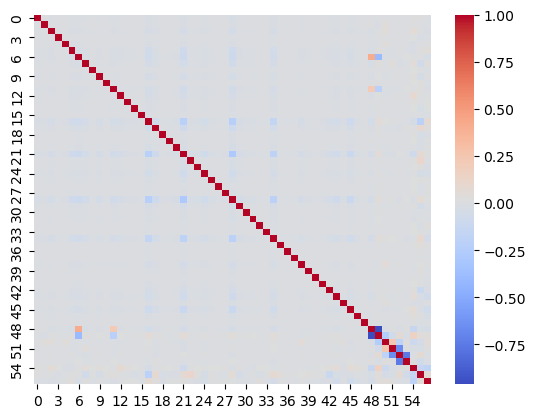

In [27]:
# heatmap to visualize correlation of our training dataset
sns.heatmap((transformedToDf(X_train)).corr(), annot=None, cmap='coolwarm')

## 6. Build and evaluate linear regression models

In [28]:
# linear regression model
reg = LinearRegression()
# train model
reg.fit(X_train, y_train)

# Test model on testing subset!
salary_predictions = reg.predict(X_test)
salary_predictions

array([205623.50028814, 175975.55015311, 148124.5874634 , ...,
       237560.18861599, 178401.48658244, 173082.5942948 ])

In [29]:
# Evaluate the model's performance
mse = mean_squared_error(y_test, salary_predictions)
r2 = r2_score(y_test, salary_predictions)

print(mse)
print(r2)

3682845321.418654
0.22193885375095113


#### The model's poor performance makes me reevaluate the pipeline I applied to the df.
#### On evaluation of the my original objective and the given dataset, I only have 3 non-OneHotEncoded features to work with. So, I will stick with the pipeline for now and instead run other regression models on the training and testing data.

In [30]:
# create a function to fit and apply new models in 1 call
def applyModel(d_tuple, model):
    
    X_train, X_test, y_train, y_test = d_tuple
    #train model
    model.fit(X_train, y_train)
    #test model
    y_pred = model.predict(X_test)
    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return [mse, r2]

In [31]:
#define function input tuple
split_data_tuple = X_train, X_test, y_train, y_test

In [32]:
# model imports
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LassoCV, ElasticNetCV, SGDRegressor

# List of sparse regression models
model_list = [
    Ridge(),
    Lasso(),
    ElasticNet(),
    LassoCV(),
    ElasticNetCV(),
    SGDRegressor()
]

In [33]:
# initialize model performance dictionary with first model
model_performance = {reg: [mse, r2]}

# run models and add their performances to dictionary
for model in model_list:
    model_performance[model] = applyModel(split_data_tuple, model)

# print the performance for each model and return best-performing model
best_model_mse = None
best_model_r2 = None
best_mse = float('inf')
best_r2 = float('-inf')

for model, performance in model_performance.items():
    mse = performance[0]
    r2 = performance[1]
    print(f"{model}\nMSE:\t{mse}\nR^2:\t{r2}\n")
    
    #find best model based on mse
    if mse < best_mse:
        best_model_mse = model
        best_mse = mse
    
    if r2 > best_r2:
        best_model_r2 = model
        best_r2 = r2

print(f"Best model based on MSE:\n{best_model_mse}\t{best_mse}")
print(f"Best model based on R^2:\n{best_model_r2}\t{best_r2}")

/Users/junomarquesoda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1487103022004.6602, tolerance: 5689054632.28881
  model = cd_fast.sparse_enet_coordinate_descent(


LinearRegression()
MSE:	3682845321.418654
R^2:	0.22193885375095113

Ridge()
MSE:	3671670514.48286
R^2:	0.22429971399208293

Lasso()
MSE:	3680442080.9736543
R^2:	0.2224465774950014

ElasticNet()
MSE:	4202968759.4286866
R^2:	0.11205429356714347

LassoCV()
MSE:	3704667558.630491
R^2:	0.21732855019027375

ElasticNetCV()
MSE:	4728489376.748752
R^2:	0.0010294912189278138

SGDRegressor()
MSE:	5.018659193886101e+28
R^2:	-1.0602736157065064e+19

Best model based on MSE:
Ridge()	3671670514.48286
Best model based on R^2:
Ridge()	0.22429971399208293


#### Statistics show that Ridge regression is most accurate and shows greatest correlation of features with target (salary).
#### I also notice that the exact values change every time I rerun this notebook, likely because sklearn's 'train_test_split' function does not use a random seed for splitting the pandas dataframe. 
#### With future datasets, I will take advantage of the unfixed randomness by running several simulations of each model, returning average performance metrics, and then judging model effectiveness.